We make the 2D diffusion case in the Forward case. We take the dimensions of the 1D case so we can take the same discretization step

In [5]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 13.0 MB/s eta 0:00:00


In [2]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [3]:


# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
else:
  print("/////////////////\n Tensors type on CPU \n///////////////")
# USE_GPU = True
# device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')
# print(device)


/////////////////
 Tensors type on CPU 
///////////////


In [25]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.colors

In [49]:
Lx = 500
Ly = 500
T = 10 #Final Time
# D = 0.5*10e-4  #https://www.engineeringtoolbox.com/air-diffusion-coefficient-gas-mixture-temperature-d_2010.html
D = 50**2/10 #= l**2/t
S = 1000 #peak of the source
S_coord = torch.tensor([Lx/3, Ly/2])
space_discretization= 50 #100 points/edges of the rectangle; 5 points/second
time_discretization = 20

#Geometry and residual
geom = dde.geometry.geometry_2d.Rectangle(np.array([0, 0]), np.array([Lx, Ly]))
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [50]:
import torch.distributions as distributions

# def gaussian_distribution(tensor, mean, std):
#     '''2d gaussian with isotropic variance '''
#     covariance_matrix = torch.eye(2) * std
#     mvn = distributions.MultivariateNormal(mean, covariance_matrix)

#     return mvn.log_prob(tensor).exp()

def gaussian_distribution(tensor, mean, std):
  ''' Input:
        tensor: of shape (nb_of_point, 3)
        mean: tensor of shape (2)
        std: value of the standard deviation
      Output:
        Tensor of shape (nb_of_point, 1)

      Comment:
        I converted all the tensors to float tensor otherwise it raised me a type error
      (multiplying a double with a float..)'''


  mean = mean.float()
  position = tensor[:,0:2].float() #x = tensor[:, 0], y = tensor[:, 1]
  cov = std * torch.tensor([[1.0, 0.0], [0.0, 1.0]]).float()
  source_term = torch.exp(-0.5 * torch.sum((position - mean) @ torch.inverse(cov) * (position - mean), dim=1))

  return source_term.view((-1,1))


# Example usage
tensor = torch.tensor([[1.0, 1.0, 0]])
mean = torch.tensor([0.0, 0.0])
std = 3.0
result = gaussian_distribution(tensor, mean, std)
print(result)



tensor([[0.7165]])


torch.Size([10000, 1])


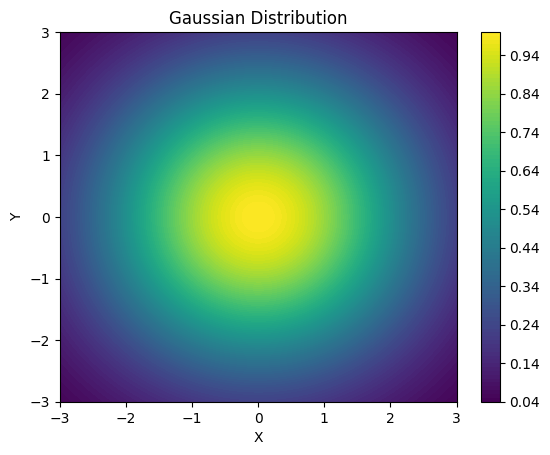

In [51]:
tensor = torch.tensor([[1.0, 1.0, 0]])

#plot
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

tensor = torch.tensor(np.dstack((X, Y)).reshape(-1, 2))
# print(tensor)
Z = gaussian_distribution(tensor, mean, std)
print(Z.shape)

Z = Z.cpu().reshape(100, 100).numpy()
plt.contourf(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gaussian Distribution')
plt.show()

In [52]:
#Residual
def pde(p, C):

    """
    Input:
      residual of the PDE. shape(p) = (nb_of_point, 3), p[i, 0] = xi; p[i, 1] = yi; p[i, 2] = ti.
      C(p) is the concentration at the point p = (x, y, t)
      P and C needs to be a pytorch tensor, otherwise it makes some strange error

    Output:
      Tensor of the residual. Shape (?) """


    # dC_x = dde.grad.jacobian(C, p, j=0)
    # dC_y = dde.grad.jacobian(C, p, j=1)
    dC_t = dde.grad.jacobian(C, p, j=2)

    dC_xx = dde.grad.hessian(C, p, i=0, j=0)
    dC_yy = dde.grad.hessian(C, p, i=1, j=1)

    return (
        - dC_t
        # - u[0] * dC_x
        # - u[1] * dC_y
        + D * (dC_xx + dC_yy)
        + gaussian_distribution(tensor=p[:, 0:2], mean=S_coord, std=200) * S
    )

In [53]:

#Conditions (Boudary & Initial)
# def IC_func(x):
#     return np.sin(np.pi * x[:, 0:1])

# def boundary(p, on_boundary):
#     return on_boundary and np.isclose(p[0],0)



def IC_func(p):
  '''Output must be of shape (len(p), 1)'''
  p_tensor = torch.tensor(p)
  return gaussian_distribution(p_tensor[:, 0:2], mean=S_coord, std=10)* S


def BC_func(p):
    return 0


ic = dde.icbc.IC(geomtime, IC_func, lambda _, on_initial: on_initial)
bc = dde.icbc.DirichletBC(geomtime, BC_func, lambda _, on_boundary: on_boundary)



# Definition des conditions aux limites
S_coord_np = S_coord.cpu().numpy()
nb_source_points = time_discretization
times = np.linspace(0, T, nb_source_points)
source_points = np.tile(S_coord_np, (nb_source_points, 1))
source_points_time = np.c_[ source_points, times]


anchor_points = source_points_time




In [1]:
#Data and model



data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=1000,
    # num_domain = 100,

    num_boundary = 200,
    # num_boundary=4*space_discretization*time_discretization

    # num_boundary= 50,
    # num_test=10000,
    anchors=anchor_points
)


layer_size = [3] + [20] * 8 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

NameError: name 'dde' is not defined

In [55]:
#Computations and graph
model.compile("adam", lr=0.01)
losshistory, train_state = model.train(iterations=3000)


Compiling model...
'compile' took 0.002145 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.81e+04, 6.54e-02, 1.00e+06]    [1.81e+04, 6.54e-02, 1.00e+06]    []  
1000      [1.81e+04, 3.82e+04, 6.47e+05]    [1.81e+04, 3.82e+04, 6.47e+05]    []  
2000      [1.81e+04, 1.16e+05, 4.34e+05]    [1.81e+04, 1.16e+05, 4.34e+05]    []  
3000      [1.81e+04, 1.93e+05, 3.14e+05]    [1.81e+04, 1.93e+05, 3.14e+05]    []  

Best model at step 3000:
  train loss: 5.25e+05
  test loss: 5.25e+05
  test metric: []

'train' took 74.903658 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


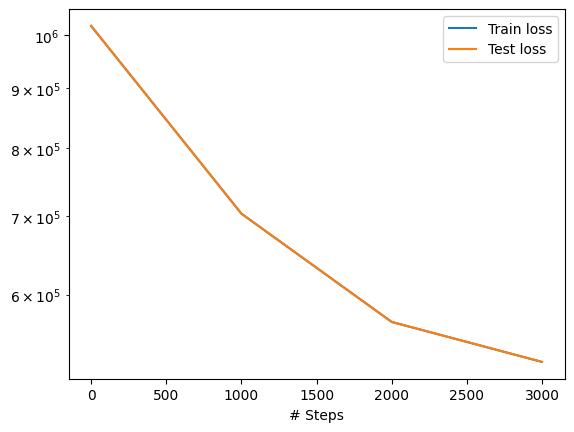

In [56]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

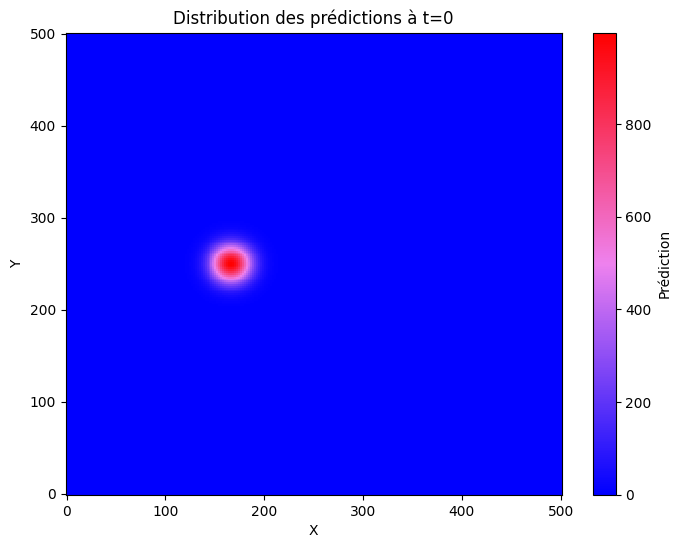

In [62]:
#Code Arnaud
# Test: on affiche le resultat au temps t
t = 0
x = geom.uniform_points(250 * 250, True)
p = np.c_[x, np.array([t] * x.shape[0])]
y = model.predict(p, operator=pde)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)

resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x[:, 0], x[:, 1]), y[:, 0], (xi, yi), method="linear")

plt.figure(figsize=(8, 6))
plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
plt.colorbar(label="Prédiction")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution des prédictions à t={}".format(t))
plt.show()

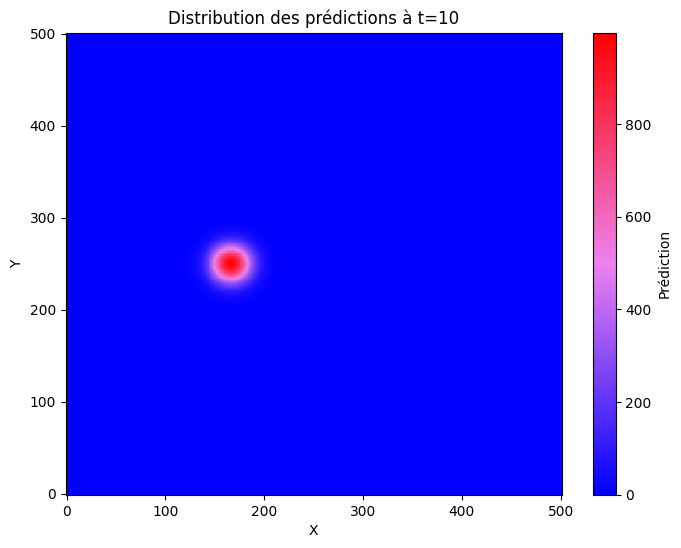

In [63]:
#Code Arnaud
# Test: on affiche le resultat au temps t
t = 10
x = geom.uniform_points(250 * 250, True)
p = np.c_[x, np.array([t] * x.shape[0])]
y = model.predict(p, operator=pde)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)

resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x[:, 0], x[:, 1]), y[:, 0], (xi, yi), method="linear")

plt.figure(figsize=(8, 6))
plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
plt.colorbar(label="Prédiction")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution des prédictions à t={}".format(t))
plt.show()

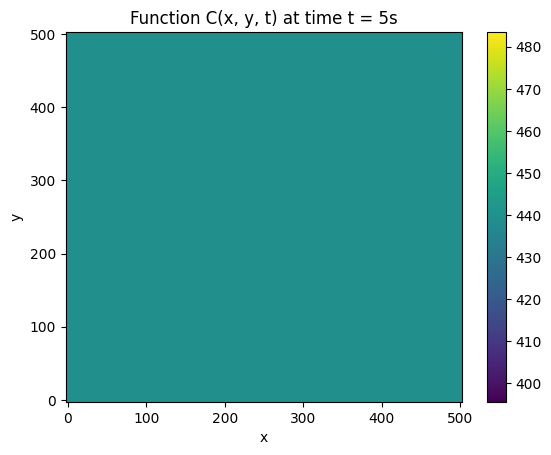

In [24]:
# Define the time t_1 at which you want to display the function
t_1 = 5

# Define the spatial domain where you want to evaluate the function in 2D
x = np.linspace(0, Lx, 100)
y = np.linspace(0, Ly, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the function C(x, y, t) at the specified time t_1 and spatial domain (x, y)
C_x_y_t1 = model.predict(np.column_stack((X.ravel(), Y.ravel(), t_1*np.ones_like(X.ravel())))).reshape(X.shape)# Plot the function C(x, y, t) at time t_1 in 2D
plt.figure()
plt.pcolormesh(X, Y, C_x_y_t1, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function C(x, y, t) at time t = {}s'.format(t_1))
plt.show()
